In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

EPS = 1e-4                            # Small epsilon to avoid divide-by-zero and extreme ratios
RANDOM_STATE = 42                     # To get reproducible results and control randomness

In [2]:
df = pd.read_csv("../data/dataset_dga.csv")
print("Shape:", df.shape)
print(df.columns.tolist())
df.head()

Shape: (589, 13)
['H2', 'CH4', 'C2H6', 'C2H4', 'C2H2', 'Fault Type', 'R1_C2H2_C2H4', 'R2_CH4_H2', 'R3_C2H4_C2H6', 'Rogers_Prediction', 'label_encoded', 'RF_Pred_encoded', 'RF_Pred_Label']


,H2,CH4,C2H6,C2H4,C2H2,Fault Type,R1_C2H2_C2H4,R2_CH4_H2,R3_C2H4_C2H6,Rogers_Prediction,label_encoded,RF_Pred_encoded,RF_Pred_Label
0,1458.0,9.0,1812.000000,0.000001,0.000001,Partial Discharge,1.000000e+00,0.006173,5.518764e-10,Unknown/Other,5,5.0,Partial Discharge
1,2240.0,157.0,90.000000,157.000000,45.000000,Partial Discharge,2.866242e-01,0.070089,1.744444e+00,Unknown/Other,5,5.0,Partial Discharge
2,73.0,8.0,4.000000,2.000000,12.000000,Partial Discharge,6.000000e+00,0.109589,5.000000e-01,Unknown/Other,5,5.0,Partial Discharge
3,235.0,16.0,0.000001,35.000000,0.000001,Partial Discharge,2.857143e-08,0.068085,3.500000e+07,Unknown/Other,5,5.0,Partial Discharge
4,9340.0,995.0,60.000000,6.000000,7.000000,Partial Discharge,1.166667e+00,0.106531,1.000000e-01,Unknown/Other,5,5.0,Partial Discharge


In [3]:
placeholder_mask = (df == 0.0001)
df = df.copy()
df[placeholder_mask] = EPS

# Ensure numeric types for gas columns
gas_cols = ['H2', 'CH4', 'C2H6', 'C2H4', 'C2H2']
for c in gas_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(EPS)

df[gas_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
H2,589.0,1489.467284,6786.213835,0.000001,34.000000,111.0,376.00,92600.0
CH4,589.0,872.805939,4267.776226,0.000001,21.000000,67.0,240.95,64064.0
C2H6,589.0,382.245574,3428.442087,0.000001,8.000000,38.0,121.00,72128.0
C2H4,589.0,989.720009,5310.138828,0.000001,10.000000,51.0,298.00,95650.0
C2H2,589.0,511.512500,3107.207062,0.000001,0.000001,8.0,89.00,57000.0


In [4]:
def compute_rogers_ratios(df):
    r1 = df['C2H2'] / df['C2H4'].replace(0, EPS)
    r2 = df['CH4'] / df['H2'].replace(0, EPS)
    r3 = df['C2H4'] / df['C2H6'].replace(0, EPS)
    return r1, r2, r3

df['R1_C2H2_C2H4'], df['R2_CH4_H2'], df['R3_C2H4_C2H6'] = compute_rogers_ratios(df)
df[['R1_C2HH2_C2H4' if 'R1_C2HH2_C2H4' in df.columns else 'R1_C2H2_C2H4', 'R2_CH4_H2', 'R3_C2H4_C2H6']] = df[['R1_C2H2_C2H4', 'R2_CH4_H2', 'R3_C2H4_C2H6']]
df.head()


,H2,CH4,C2H6,C2H4,C2H2,Fault Type,R1_C2H2_C2H4,R2_CH4_H2,R3_C2H4_C2H6,Rogers_Prediction,label_encoded,RF_Pred_encoded,RF_Pred_Label
0,1458.0,9.0,1812.000000,0.000001,0.000001,Partial Discharge,1.000000e+00,0.006173,5.518764e-10,Unknown/Other,5,5.0,Partial Discharge
1,2240.0,157.0,90.000000,157.000000,45.000000,Partial Discharge,2.866242e-01,0.070089,1.744444e+00,Unknown/Other,5,5.0,Partial Discharge
2,73.0,8.0,4.000000,2.000000,12.000000,Partial Discharge,6.000000e+00,0.109589,5.000000e-01,Unknown/Other,5,5.0,Partial Discharge
3,235.0,16.0,0.000001,35.000000,0.000001,Partial Discharge,2.857143e-08,0.068085,3.500000e+07,Unknown/Other,5,5.0,Partial Discharge
4,9340.0,995.0,60.000000,6.000000,7.000000,Partial Discharge,1.166667e+00,0.106531,1.000000e-01,Unknown/Other,5,5.0,Partial Discharge


In [5]:

def rogers_classify(r1, r2, r3):
    # r1 = C2H2/C2H4, r2 = CH4/H2, r3 = C2H4/C2H6]
    try:
        if (r1 < 0.1) and (r2 >= 0.1 and r2 <= 1.0) and (r3 < 1.0):
            return "Normal"
        if (r1 < 0.1) and (r2 < 0.1) and (r3 < 1.0):
            return "Partial Discharge (PD) / Low Energy Discharge"
        if (r1 >= 0.1 and r1 <= 3.0) and (r2 >= 0.1 and r2 <= 1.0) and (r3 > 3.0):
            return "High Energy Discharge (Arcing)"
        if (r1 < 0.1) and (r2 >= 0.1 and r2 <= 1.0) and (r3 >= 1.0 and r3 <= 3.0):
            return "Low Temperature Overheating"
        if (r1 < 0.1) and (r2 > 1.0) and (r3 >= 1.0 and r3 <= 3.0):
            return "Medium Temperature Overheating (<700C)"
        if (r1 < 0.1) and (r2 > 1.0) and (r3 > 3.0):
            return "High Temperature Overheating (>700C)"
        # If none matched, return Unknown
        return "Unknown/Other"
    except Exception:
        return "Unknown/Other"

df['Rogers_Prediction'] = df.apply(lambda row: rogers_classify(row['R1_C2H2_C2H4'], row['R2_CH4_H2'], row['R3_C2H4_C2H6']), axis=1)
df[['R1_C2H2_C2H4', 'R2_CH4_H2', 'R3_C2H4_C2H6', 'Rogers_Prediction']].head(10)


,R1_C2H2_C2H4,R2_CH4_H2,R3_C2H4_C2H6,Rogers_Prediction
0,1.000000e+00,0.006173,5.518764e-10,Unknown/Other
1,2.866242e-01,0.070089,1.744444e+00,Unknown/Other
2,6.000000e+00,0.109589,5.000000e-01,Unknown/Other
3,2.857143e-08,0.068085,3.500000e+07,Unknown/Other
4,1.166667e+00,0.106531,1.000000e-01,Unknown/Other
5,5.000000e-07,0.018731,3.448276e-02,Partial Discharge (PD) / Low Energy Discharge
6,1.000000e+00,0.128357,4.545455e-08,Unknown/Other
7,1.263158e+00,0.069130,1.165644e-01,Unknown/Other
8,1.000000e+00,0.146789,1.000000e+00,Unknown/Other
9,4.000000e+06,0.185841,2.083333e-08,Unknown/Other


In [6]:
label_col = 'Fault Type'
if label_col not in df.columns:
    raise RuntimeError(f"Label column '{label_col}' not found in dataframe. Columns: {df.columns.tolist()}")

print("Unique labels (raw):", df[label_col].unique())

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df[label_col].astype(str))
print("Label classes:", list(le.classes_))

df["TotalGas"] = df["H2"] + df["CH4"] + df["C2H6"] + df["C2H4"] + df["C2H2"]
feature_cols = ['R1_C2H2_C2H4', 'R2_CH4_H2', 'R3_C2H4_C2H6', 'TotalGas']
X = df[feature_cols].values
y = df['label_encoded'].values

# Train/test split (stratify to maintain label distribution)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index.values, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)


Unique labels (raw): ['Partial Discharge' 'Low Energy Discharge'
 'High Energy Discharge (Arcing)' 'Low Temperature Overheating'
 'Medium Temperature Overheating' 'High Temperature Overheating']
Label classes: ['High Energy Discharge (Arcing)', 'High Temperature Overheating', 'Low Energy Discharge', 'Low Temperature Overheating', 'Medium Temperature Overheating', 'Partial Discharge']


In [7]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
clf.fit(X_train_s, y_train)

# Predictions
y_pred = clf.predict(X_test_s)
print("Accuracy (Random Forest):", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy (Random Forest): 0.847457627118644

Classification report:
                                 precision    recall  f1-score   support

High Energy Discharge (Arcing)       0.81      0.87      0.84        30
  High Temperature Overheating       0.91      1.00      0.95        21
          Low Energy Discharge       0.65      0.72      0.68        18
   Low Temperature Overheating       0.91      0.95      0.93        22
Medium Temperature Overheating       1.00      0.75      0.86        12
             Partial Discharge       0.91      0.67      0.77        15

                      accuracy                           0.85       118
                     macro avg       0.87      0.83      0.84       118
                  weighted avg       0.86      0.85      0.85       118



In [8]:
rogers_to_label = {
    "Partial Discharge (PD) / Low Energy Discharge": "Partial Discharge",
    "Partial Discharge": "Partial Discharge",
    "High Energy Discharge (Arcing)": "High Energy Discharge (Arcing)",
    "Low Temperature Overheating": "Low Temperature Overheating",
    "Medium Temperature Overheating (<700C)": "Medium Temperature Overheating",
    "High Temperature Overheating (>700C)": "High Temperature Overheating",
    "Normal": "Normal",
}

test_indices = idx_test
rogers_preds_test = df.loc[test_indices, 'Rogers_Prediction'].map(rogers_to_label).fillna("Unknown/Other").values

def encode_roger_label(lbl):
    try:
        return le.transform([lbl])[0]
    except ValueError:
        return -1

rogers_encoded = np.array([encode_roger_label(lbl) for lbl in rogers_preds_test])

# Accuracy where Rogers maps to known labels
valid_mask = rogers_encoded != -1
if valid_mask.sum() > 0:
    rogers_acc = (rogers_encoded[valid_mask] == y_test[valid_mask]).mean()
    print(f"Rogers-method accuracy on test rows with mappable labels: {rogers_acc:.4f} ({valid_mask.sum()} rows)")
else:
    print("No Rogers predictions could be mapped to dataset labels for accuracy comparison.")


Rogers-method accuracy on test rows with mappable labels: 0.9259 (54 rows)


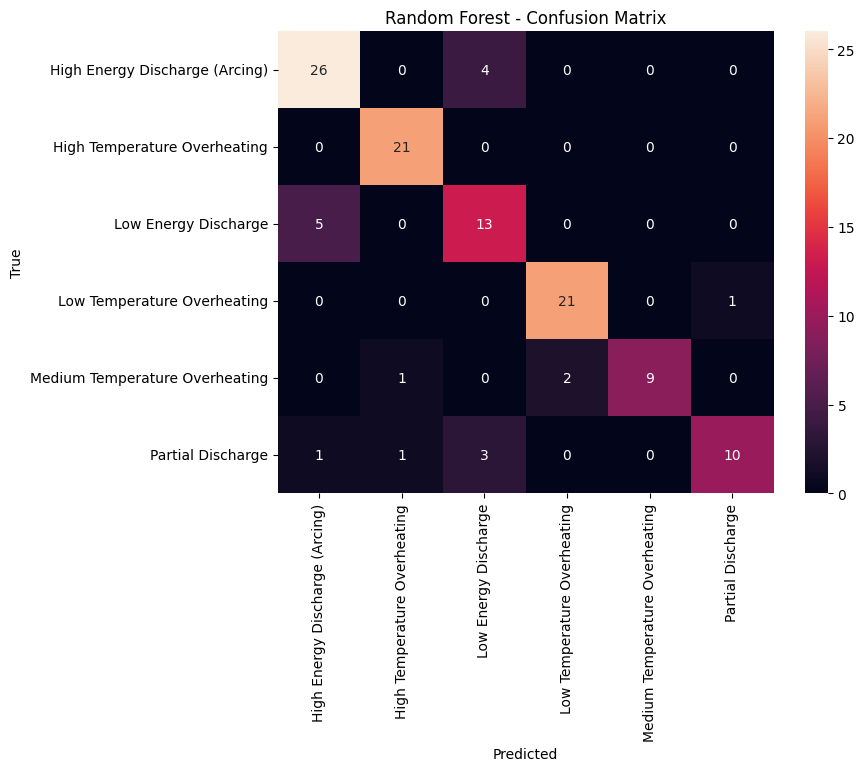

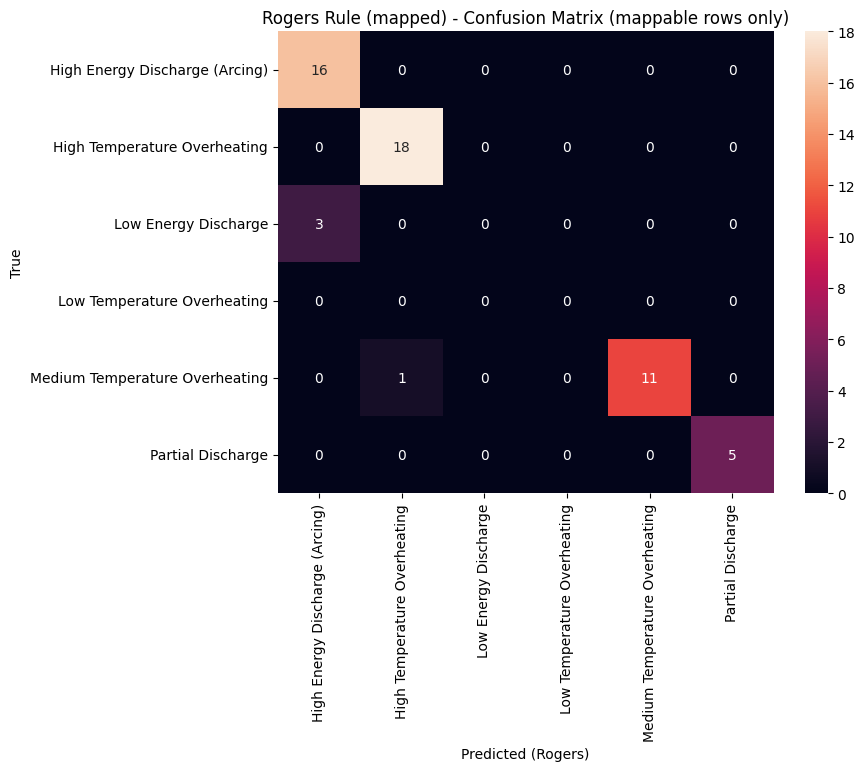

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# RF confusion matrix
cm_rf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Rogers confusion (only for mappable rows)
if valid_mask.sum() > 0:
    cm_rogers = confusion_matrix(y_test[valid_mask], rogers_encoded[valid_mask], labels=range(len(le.classes_)))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_rogers, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Rogers Rule (mapped) - Confusion Matrix (mappable rows only)")
    plt.xlabel("Predicted (Rogers)")
    plt.ylabel("True")
    plt.show()


In [10]:
df.loc[idx_test, 'RF_Pred_encoded'] = y_pred
df.loc[idx_test, 'RF_Pred_Label'] = le.inverse_transform(y_pred)
df.loc[idx_train, 'RF_Pred_encoded'] = clf.predict(X_train_s)
df.loc[idx_train, 'RF_Pred_Label'] = le.inverse_transform(clf.predict(X_train_s))

df.to_csv("dataset_dga_output.csv", index=False)
